<center> <h5> EL7022 - Procesamiento de Voz en Telecomunicaciones </h5> </center>


<center> <h1> Proyecto Final <br />
Reconocimiento de Emociones en Voz Usando Redes Recurrentes </h1>
<h3>
Integrantes: Giovanni Castiglioni y Nicolás Fernández <br />
Profesor: Néstor Becerra <br />
Profesor Auxiliar: Ricardo García <br />
Semestre: Primavera 2023
</h3> </center>

# Contextualización

El reconocimiento de emociones mediante la voz, en inglés Speech Emotion Recognition (`SER`), representa un avance significativo en la creación de robots sociales capaces de entender y responder a las necesidades humanas. Estos sistemas utilizan patrones vocales para identificar el estado emocional de un usuario, lo cual es crucial para el desarrollo de interacciones hombre-máquina más naturales y efectivas. A diferencia de los métodos que dependen del análisis visual, el `SER` aprovecha la voz humana, la cual es menos susceptible a obstrucciones o variaciones en la visibilidad, como podría ser el caso cuando la cara está parcialmente oculta.

Con el objetivo de mejorar la interacción entre humanos y máquinas, el proyecto a realizar busca implementar un sistema `SER` utilizando técnicas de Deep Learning. Este enfoque se centra en procesar señales de audio para determinar la emoción expresada por el usuario. A través de la extracción de características y la clasificación de emociones, el sistema desarrollado deberá discernir entre diferentes estados afectivos, como felicidad, tristeza o neutralidad.

# Propuesta de Solución

Los features que se utilizarán para caracterizar los audios del dataset a trabajar corresponden a coeficientes LPC y coeficientes MFCC.

Los coeficientes LPC son efectivos para modelar los formantes de la voz, que son concentraciones de energía alrededor de ciertas frecuencias y son cruciales para la identificación de sonidos vocálicos en el habla. Esta característica puede ser sumamente relevante para un sistema `SER`, ya que los formantes pueden variar con las distintas emociones.

Aunque los coeficientes LPC no conservan directamente la información de tono de la voz, son capaces de reconstruir la forma de onda de la señal de habla cuando se complementan con un tren de impulsos.

Por otra parte, los coeficientes MFCC se basan en la escala mel, que está diseñada para imitar la percepción no lineal del oído humano de las frecuencias. Además, los coeficientes MFCC proporcionan una representación del espectro de energía de la voz que captura las características importantes para el reconocimiento de emociones, como las variaciones en la energía y la dinámica de las frecuencias a lo largo del tiempo.

Es por ello que, mientras que los coeficientes LPC son buenos para modelar la forma de la onda de la señal de habla y sus propiedades de resonancia, los coeficientes MFCC son robustos en capturar la textura y la calidad del sonido relacionada con la percepción humana, por lo que la combinación de ambos coeficientes proporciona una mayor información sobre la voz que permitiría identificar emociones en esta.

Respecto a las arquitecturas de modelos a utilizar, se tendrá un mayor enfoque temporal, por lo que los modelos recurrentes son útiles para procesar secuencias de datos en donde la información emocional está distribuida a lo largo de la señal de habla.

# Dataset

La base de datos a utilizar durante este proyecto corresponde al Dataset CREMA-D. Este consta de 7442 audios de 91 actores masculinos y femeninos. Estos grabaron 12 oraciones con 6 distintas emociones:

* Enojo
* Disgusto
* Miedo
* Felicidad
* Neutral
* Tristeza

Y 4 niveles distintos de emoción:

* Bajo
* Medio
* Alto
* No Especificado

# Desarrollo

Se comienza importando las librerías necesarias para el desarrollo del proyecto.

In [1]:
import os
!pip install torchmetrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
from torchmetrics import ConfusionMatrix
from tqdm.notebook import tqdm
import h5py
!pip install focal_loss_torch
from focal_loss.focal_loss import FocalLoss
device = 'cuda'

!mkdir results
!mkdir test

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.5 MB/s eta 0:00:00
mkdir: cannot create directory ‘results’: File exists
mkdir: cannot create directory ‘test’: File exists


Luego, se carga el dataset de audios preprocesado previamente. A cada audio se le obtuvieron sus coeficientes LPC de orden 13 resolviendo el sistema

> $R(i) = ∑_{k=1}^{p} a_{k}R(i-k)$

En donde $R$ corresponde a la matriz de correlación de cada ventana de las señales y $p$ corresponde al orden. Por otra parte, los coeficientes MFCC se obtuvieron usando la función `mfcc()` de las librerías `python_speech_features`.

Dado el gran tamaño del dataset de audios, los features obtenidos en el preprocesamiento se almacenaron en 2 archivos `.h5`, para lo cual, al momento de descompresión, fue necesario recuperar el nombre del archivo de audio y la emoción a la que correspondía cada feature. Esta información se encontraba previamente almacenada en el archivo `Audios.csv`.

Con esto se crean los conjuntos `x_set` en el que se tienen los coeficientes LPC de cada audio, `x_set_mfcc` en el que se tienen los coeficientes MFCC de cada audio, y `y_set` en el que se tiene el sentimiento asociado a cada audio.

Cabe destacar que de los 7442 audios originales, se trabajarán con 7435 debido a ciertos problemas en algunos audios. La distribución de emociones entre los audios del dataset está en su mayoría balanceada, teniendo 5 de las 6 emociones una cantidad cercana a 1270 audios por cada emoción. Sin embargo, la emoción "Neutral" posee una menor cantidad de audios con un total de 1086 audios.

Posteriormente se definen funciones auxiliares llamadas `split_data()`, `show_confusion_matrix()` y `show_statistics()`.

La primera de estas permite separar el dataset de audios de CREMA-D en 3 conjuntos de entrenamiento, validación y prueba de forma aleatoria. Las proporciones de cada conjunto de datos es 75%, 15% y 10% respectivamente.

La segunda función auxiliar permite visualizar la matriz de confusión de los modelos tras ser entrenamos 5 veces obteniendo métricas promedio y error de todos los entrenamientos realizados. Mientras que la tercera función muestra la matriz de confusión para 1 modelo entrenado en particular, enseñando sus métricas obtenidas de igual forma.

In [4]:
dataframe = pd.read_csv('Audios.csv')

files = np.array(dataframe['name'])
labels = np.array(dataframe['label'])

for cosa in np.unique(labels):
  print(f"{cosa}: {list(labels).count(cosa)}")

label2class = {'ANG': 0,
               'DIS': 1,
               'FEA': 2,
               'HAP': 3,
               'NEU': 4,
               'SAD': 5}

f = h5py.File('AudiosLPC.h5', 'r')

x_set, y_set = torch.FloatTensor(), []

for k in range(len(files)):
  name = files[k]
  x_set = torch.cat((x_set, torch.from_numpy(f[name][:,:].astype(np.float32)).unsqueeze(dim=0)), dim = 0)
  y_set.append(label2class[labels[k]])
y_set = torch.LongTensor(y_set)

f = h5py.File('AudiosMFCC.h5', 'r')

x_set_mfcc = torch.FloatTensor()

for k in range(len(files)):
  name = files[k]
  new_mfcc = torch.from_numpy(f[name][:,:].astype(np.float32)).unsqueeze(dim=0)
  x_set_mfcc = torch.cat((x_set_mfcc, new_mfcc), dim = 0)

def split_data(x_set, x_set_mfcc, y_set, network="RNN", it = 0):

    indices = torch.randperm(x_set.shape[0])

    x_set = x_set[indices]
    x_set_mfcc = x_set_mfcc[indices]
    y_set = y_set[indices]


    x_train = x_set[int(0.25*len(x_set)):]
    x_val = x_set[:int(0.15*len(x_set))]
    x_test = x_set[int(0.15*len(x_set)):int(0.25*len(x_set))]

    x_train_mfcc = x_set_mfcc[int(0.25*len(x_set)):]
    x_val_mfcc = x_set_mfcc[:int(0.15*len(x_set))]
    x_test_mfcc = x_set_mfcc[int(0.15*len(x_set)):int(0.25*len(x_set))]

    maximum_lpc = abs(x_train).max()
    maximum_mfcc = abs(x_train_mfcc).max()

    x_train = torch.cat((x_train/maximum_lpc, x_train_mfcc/maximum_mfcc), dim=2)
    x_val = torch.cat((x_val/maximum_lpc, x_val_mfcc/maximum_mfcc), dim=2)
    x_test = torch.cat((x_test/maximum_lpc, x_test_mfcc/maximum_mfcc), dim=2)


    y_train = y_set[int(0.25*len(x_set)):]
    y_val = y_set[:int(0.15*len(x_set))]
    y_test = y_set[int(0.15*len(x_set)):int(0.25*len(x_set))]


    torch.save(x_test, f"/content/test/input_{network}_{it}.pt")
    torch.save(y_test, f"/content/test/target_{network}_{it}.pt")

    return x_train, x_val, x_test, y_train, y_val, y_test

ANG: 1270
DIS: 1269
FEA: 1270
HAP: 1271
NEU: 1086
SAD: 1269


A continuación se pueden observar ejemplos de coeficientes LPC y MFCC para un audio cualquiera del dataset.

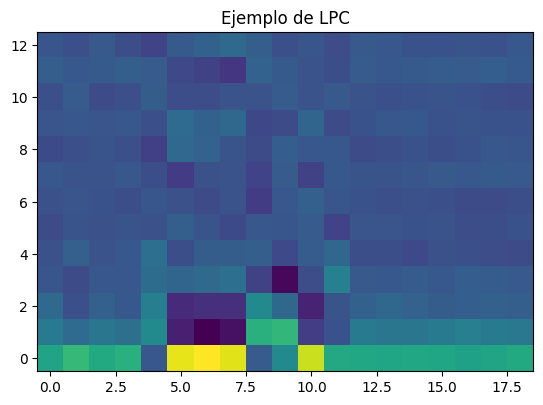

In [ ]:
plt.imshow(x_set[456].transpose(1,0), origin="lower")
plt.title("Ejemplo de LPC")
plt.show()

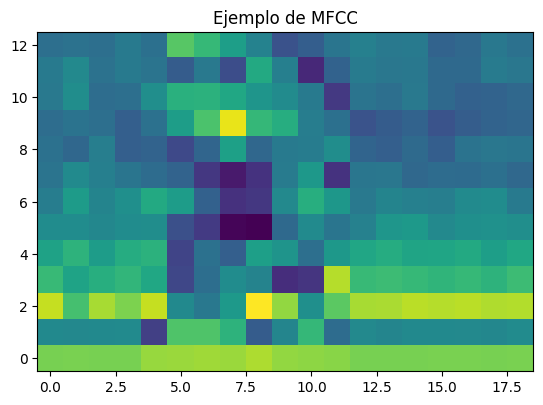

In [ ]:
plt.imshow(x_set_mfcc[456].numpy().transpose(1,0), origin="lower")
plt.title("Ejemplo de MFCC")
plt.show()

In [10]:
def show_confusion_matrix(confusion, network="RNN"):

    totales = np.array([np.sum(confusion[i]) for i in range(6)]).astype(np.int64)

    cm = np.zeros((6,6))
    for i in range(6):
      for j in range(6):
        cm[i,j] = confusion[i,j]/totales[i]

    plt.imshow(cm, cmap=plt.cm.Blues)

    class_labels = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]*100:.2f}%', horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xticks(range(len(class_labels)), class_labels)
    plt.yticks(range(len(class_labels)), class_labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.yticks([0, 1, 2, 3, 4, 5])
    plt.title(f"{network} Confusion Matrix")
    plt.colorbar()
    plt.show()

In [11]:
def show_statistics(cm, network):

    mean_values = cm.mean(axis=0)
    std_values = cm.std(axis=0)

    totales = np.array([np.sum(mean_values[i]) for i in range(6)]).astype(np.int64)

    m = np.zeros((6,6))
    s = np.zeros((6,6))
    for i in range(6):
      for j in range(6):
        m[i,j] = mean_values[i,j]/totales[i]
        s[i,j] = std_values[i,j]/totales[i]

    mean_values = m
    std_values = s

    plt.figure(figsize = (12,12))
    plt.imshow(mean_values, cmap=plt.cm.Blues)

    class_labels = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

    thresh = mean_values.max() / 2.
    for i in range(mean_values.shape[0]):
        for j in range(mean_values.shape[1]):
            plt.text(j, i, f'{mean_values[i, j]*100:.2f}% ± {std_values[i, j]*100:.2f}%', horizontalalignment="center",
                     color="white" if mean_values[i, j] > thresh else "black")

    plt.xticks(range(len(class_labels)), class_labels)
    plt.yticks(range(len(class_labels)), class_labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.yticks([0, 1, 2, 3, 4, 5])
    plt.title(f"{network} Confusion Matrix")
    plt.colorbar()
    plt.show()

## Implementación y Entrenamiento de los modelos

Para el entrenamiento de los modelos Vanilla RNN y RNN LSTM se entrenarán por 350 épocas, se utilizarán 26 features por cada época (13 LPC y 13 MFCC) con un batch size de 32.

De igual forma, se utilizará un learning rate de $10^{-4}$ con un cycling learning rate scheduler de 750 training steps, en conjunto también de un optimizador AdamW, con el que se considerarán los pesos de manera individual para su actualización, favoreciendo a los modelos recurrentes que se desean entrenar. Respecto a los pesos, estos se inicializaron con una distribución de Kaiming He. Para el caso del modelo LSTM, el bias de la capa forget fue inicializado en 1.

También, se utilizará la función FocalLossSoftMax con el objetivo de lograr que durante el proceso de entrenamiento se dé mayor prioridad en el ajuste de pesos a los ejemplos mal clasificados, donde ese énfasis se regula con el parámetro gamma que para el caso del modelo Vanilla está seteado en 4 y para el modelo LSTM está seteado en 3.

Para cada arquitectura, se realizarán 5 iteraciones de entrenamiento para reportar un promedio y desviación estándar del accuracy de cada modelo, así como también el mejor modelo en cada caso, seleccionando los mejores pesos en base al F1 Score.

<h2>Vanilla RNN: Implementación</h2>

Sea $x=\{x_1, x_2, \ldots, x_T\}$ una secuencia de entrada de $T=19$ pasos y $F=26$ características por paso. Es decir, $x_k\in\mathbb{R}^F,\ k\in\{1,2,\ldots,T\}$. Sea $y\in\{0,1,\ldots,C-1\}$ la clase a la que pertenece la secuencia $x$, de $C=6$ clases posibles.

Se implementa la siguiente RNN:

$$ h_0 = \vec{0}$$
$$ h_k = \tanh \left( W\begin{bmatrix}x_k\\h_{k-1}\end{bmatrix} + b \right),\ \ k\in\{1,2,\ldots, T\}$$
$$ z = W_zh_T+b_z$$
$$\hat{y} = \mathrm{argmax}(z)$$

Donde $h_k\in\mathbb{R}^H$ es el estado oculto, $H$ es la dimensionalidad de la capa recurrente, $h_0$ es un estado inicial nulo, $W$ y $b$ son los pesos y sesgos de la capa recurrente, $W_z$ y $b_z$ son los pesos y sesgos de la capa de salida, $z\in\mathbb{R}^C$ son los logits calculados a partir del último estado $h_T$, e $\hat{y}\in\{0,1,\ldots,C-1\}$ es la clase predicha por la RNN.

In [6]:
class FocalLossSoftMax(nn.Module):
  def __init__(self, gamma=3.0):
    super(FocalLossSoftMax, self).__init__()
    self.loss = FocalLoss(gamma)
    self.softmax = nn.Softmax(dim=1)
  def forward(self, pred, target):
    return self.loss(self.softmax(pred), target)

In [7]:
class ModelVanillaRNN(nn.Module):
    def __init__(
        self,
        learning_rate,
        n_input_features=26,
        n_input_steps=19,
        n_hidden_dimension=16,
        n_classes=6,
        batch_size=32,
        n_epochs=150
    ):

        super(ModelVanillaRNN, self).__init__()
        self.learning_rate = learning_rate
        self.n_input_features = n_input_features
        self.n_input_steps = n_input_steps
        self.n_hidden_dimension = n_hidden_dimension
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.CE = FocalLossSoftMax(gamma=4.0)

        # Capa de entrada que recibe el vector concatenado
        self.fc1 = torch.nn.Linear(self.n_input_features + self.n_hidden_dimension, self.n_hidden_dimension)
        nn.init.kaiming_uniform_(self.fc1.weight.data)

        # Función de activacion a usar en esta arquitectura
        self.tanh = torch.nn.Tanh()

        # Capa de salida
        self.fc2 = torch.nn.Linear(self.n_hidden_dimension, self.n_input_steps)
        nn.init.kaiming_uniform_(self.fc2.weight.data)

        self.fc3 = torch.nn.Linear(self.n_input_steps, self.n_classes)
        nn.init.kaiming_uniform_(self.fc3.weight.data)

        self.confusion_matrix = ConfusionMatrix(num_classes=self.n_classes, task='multiclass')

        self.ReLU = nn.ReLU()

        self.bn = nn.BatchNorm1d(self.n_input_steps)


    # Esta funcion define el flujo de informacion en la red al evaluar un conjunto de datos
    # entregados en la forma de un tensor de PyTorch.
    def forward(self, batch):
        # El primer estado se inicializa nulo.
        h_k = torch.zeros(len(batch), self.n_hidden_dimension).type(torch.FloatTensor).to(device)

        # Se calcula el estado h_T para cada elemento del batch a partir de inicializar
        # el proceso desde el primero de los 19 vectores de 26 características.
        for step in range(self.n_input_steps):
          x_k = torch.cat((batch[:, step, :], h_k), 1)

          h_k = self.fc1(x_k)
          h_k = self.tanh(h_k)

        # Una vez obtenido h_T, este pasa a la capa de salida.
        z = self.fc3(self.ReLU(self.bn(self.fc2(h_k))))
        return z

    # Realiza el entrenamiento de la red con los datos que se le entreguen durante
    # las epocas que se le especifiquen a la clase al ser iniciada.
    # Retorna las curvas de aprendizaje (Loss y Accuracy) para los conjuntos de
    # entrenamiento y validacion.
    def fit(self, x_train, y_train, x_val, y_val, it=1):

        # En primer lugar se define el optimizador y los parametros a optimizar con
        # las especificaciones pedidas en el enunciado, junto a la función de perdida.

        optimizer = torch.optim.AdamW([
            {'params': [self.fc2.weight, self.fc2.bias,
                        self.fc1.weight, self.fc1.bias,
                        self.fc3.weight, self.fc3.bias,
                        self.bn.weight, self.bn.bias]}],
            lr=self.learning_rate)

        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                                                      base_lr=self.learning_rate,
                                                      max_lr=10*self.learning_rate,
                                                      cycle_momentum=False,
                                                      step_size_up=750)

        xentropy = self.CE

        # Se inicializan las curvas de aprendizaje que seran actualizadas durante el proceso.
        train_loss = np.zeros(self.n_epochs)
        val_loss = np.zeros(self.n_epochs)
        train_accuracy = np.zeros(self.n_epochs)
        val_accuracy = np.zeros(self.n_epochs)
        val_F1 = np.zeros(self.n_epochs)

        # Por buenas prácticas, en lugar de calcular exhaustivamente el largo de los conjuntos
        # cuando dicha cantidad deba ser usada, este valor será guardado en memoria para acceder
        # de manera directa y optimizar el tiempo de cómputo.
        len_y_train = len(y_train)
        len_y_val = len(y_val)

        # Se da inicio al proceso.

        best = 0.0
        early = 0

        progress = tqdm(range(self.n_epochs))
        for epoch in progress:
          self.train()
          indices = torch.randperm(x_train.shape[0])
          x_train = x_train[indices]
          y_train = y_train[indices]

          for run in range(len_y_train//self.batch_size):
            # Se selecciona el batch de datos con self.batch_size cantidad de muestras
            x_batch = x_train[run*self.batch_size : (run+1)*self.batch_size].to(device)
            z_target = y_train[run*self.batch_size : (run+1)*self.batch_size].to(device)
            # Se obtienen las salidas de la red.
            z_pred = self.forward(x_batch)

            # Se realiza el algoritmo de retropropagación seteando los gradientes
            # anteriores en 0 y calculando los nuevos gradientes.
            optimizer.zero_grad()
            loss = xentropy(z_pred, z_target)
            loss.backward()
            optimizer.step()
            scheduler.step()

          # Se evaluan las métricas de desempeño sobre los conjuntos de entrenamiento
          # y validación completos, guardando estas en las curvas inicializadas antes.
          self.eval()
          train_loss[epoch] = self.eval_loss(x_train, y_train)
          val_loss_epoch = self.eval_loss(x_val, y_val)
          val_loss[epoch] = val_loss_epoch
          train_accuracy[epoch], F1_train = self.evaluate(x_train, y_train)
          val_accuracy[epoch], F1_val = self.evaluate(x_val, y_val)
          val_F1[epoch] = np.mean(F1_val)

          if np.mean(val_F1[epoch]) > best:
            best = np.mean(val_F1[epoch])
            torch.save(self.state_dict(), f"/content/results/weights_vanilla_{it}.pt")

          progress.set_postfix({'loss validation': val_loss_epoch})

          #---------------TERMINA LA EPOCA----------------#

        # Se guardan las curvas obtenidas en una 4-tupla llamada training_curves,
        # que luego se retorna como salida del método fit

        try:
          training_curves = (train_loss[:np.min(np.where(train_loss==0)[0])],
                             val_loss[:np.min(np.where(val_loss==0)[0])],
                             train_accuracy[:np.min(np.where(train_accuracy==0)[0])],
                             val_accuracy[:np.min(np.where(val_accuracy==0)[0])],
                             val_F1[:np.min(np.where(val_F1==0)[0])])
        except:
          training_curves = (train_loss,
                             val_loss,
                             train_accuracy,
                             val_accuracy,
                             val_F1)
        return training_curves

    # Recibe tensores de PyTorch o arreglos de NumPy con entradas y targets de estas,
    # y calcula el accuracy de los conjuntos que se le entreguen.
    def evaluate(self, x, y):
        batch_size = len(y)

        # Mediante la matriz de confusion, se obtiene el accuracy sumando los elementos
        # de la diagonal y dividiendo dicha suma por el total de elementos ingresados,
        # y luego se retorna dicho valor.
        confusion = self.get_confusion_matrix(x, y)

        F1 = self.F1(confusion.cpu().numpy())

        accuracy = (torch.sum(torch.Tensor([confusion[n,n] for n in range(self.n_classes)])) / batch_size)

        return accuracy, F1

    def get_confusion_matrix(self, x, y):

      z = self.forward(x.to(device))
      pred = torch.argmax(z, dim=1)

      return self.confusion_matrix(pred, y.to(device))

    def F1(self, cm):
      FP = cm.sum(axis=0) - np.diag(cm)
      FN = cm.sum(axis=1) - np.diag(cm)
      TP = np.diag(cm)

      # F1 Score
      F1 = TP/(TP+ 0.5*(FP+FN))
      return F1


    # Recibe tensores de PyTorch, y calcula la Cross Entropy Loss entre las predicciones
    # realizadas para cada clase segun el conjunto de datos de entrada entregado, y el
    # vector de ground truth para dichos datos. Luego retorna este valor.
    def eval_loss(self, x, z):
      with torch.no_grad():
        z_pred = self.forward(x.to(device))
        loss = self.CE(z_pred, z.to(device))
      return loss.cpu().item()

<h2>Vanilla RNN: Entrenamiento</h2>

Entrenamiento del modelo Vanilla.

In [ ]:
learning_rate = 0.0001

vanilla_rnn_training_curves_list = []
vanilla_rnn_val_accuracy_list = []
for i in range(5):
    x_train, x_val, x_test, y_train, y_val, y_test = split_data(x_set, x_set_mfcc, y_set, network="vanilla", it=i)
    my_rnn = ModelVanillaRNN(learning_rate=learning_rate, n_epochs=350).to(device)
    # Train model
    training_curves = my_rnn.fit(x_train, y_train, x_val, y_val, it=i)
    # Evaluate model
    val_accuracy = my_rnn.evaluate(x_val, y_val)
    # Save reports for later
    vanilla_rnn_training_curves_list.append(training_curves)
    vanilla_rnn_val_accuracy_list.append(val_accuracy)

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

<h2>Vanilla RNN: Análisis</h2>

A continuación se observan las curvas de entrenamiento y validación de cada una de las 5 iteraciones que se realizaron para entrenar. Destacar que en cada uno de estos, se identifica el modelo con mejores resultados como una curva de color rojo, mientras que el resto de curvas son de color azul.

Al analizar las curvas de pérdidas se puede observar que tanto para los casos de entrenamiento y validación los valores presentan una tendencia a la baja, alcanzando valores bajo 0.4 hacia el final de la curva de entrenamiento, y bajo 0.5 hacia el final de la curva de validación. Lo cual es bueno pues significa que el modelo está aprendiendo, así como también no se observa un aumento significativo en las curvas de pérdidas, lo que significa que el modelo no se está sobreajustando y aún es capaz de generalizar ante datos que desconoce.

Luego, al analizar las curvas de accuracy de entrenamiento y validación, se puede ver que en ambos casos los modelos presentan un aprendizaje rápido durante las primera épocas, para luego alcanzar un plateau sobre 0.5 para el conjunto de entrenamiento y ligeramente menor a 0.5 para el conjunto de validación, por lo que se puede considerar que los modelos lograron aprender en base a los features entregados y a la arquitectura diseñada.

Finalmente, analizando el gráfico de F1 Score para el conjunto de validación, se puede ver que las curvas convergen y se estabilizan a medida que pasan las épocas. Lo que se mantiene acorde con los comportamientos de las curvas presentadas en los gráficos anteriores. Por otra parte, el entrenamiento que presentó mejor F1 Score correspondió a la iteración 1, teniendo un F1 Score de 0.51 y un accuracy de 0.51 igualmente.

En cada uno de los gráficos presentados se pueden observar peaks constantes en su comportamiento, lo cual es provocado por el cycling learning rate scheduler, ya que de manera lineal se va variando el learning rate durante 750 training steps hasta alcanzar un máximo de 10 veces el valor original ($10^{-4}$) y luego baja de forma lineal durante 750 training steps hasta alcanzar el valor original.

Un F1 Score de aproximadamente 0.5 muestra que aún hay posible márgen de mejora, ya que el F1 Score indica que el modelo es medianamente efectivo en la clasificación de las clases positivas ("Total Positive"), pero hay espacio considerable para mejorar el equilibrio entre evitar falsos positivos ("False Positive") y falsos negativos ("False Negative").

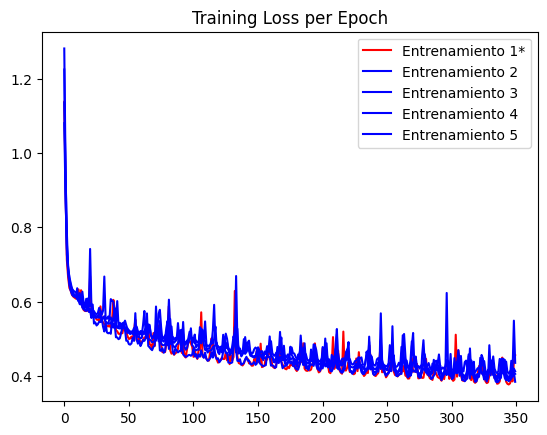

------------------------------------


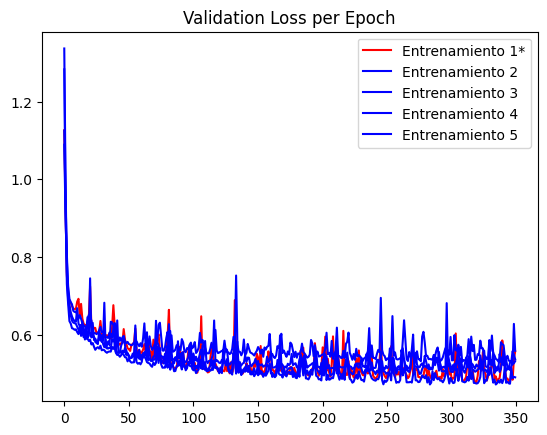

------------------------------------


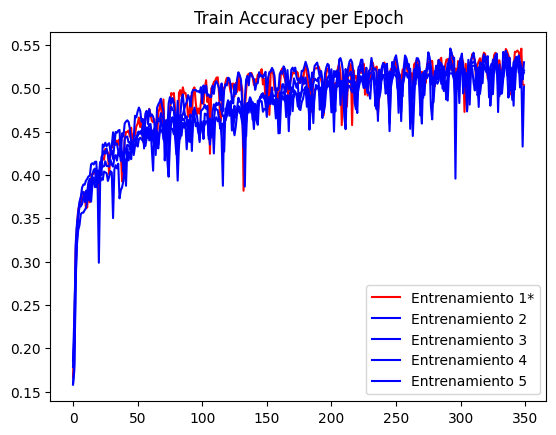

------------------------------------


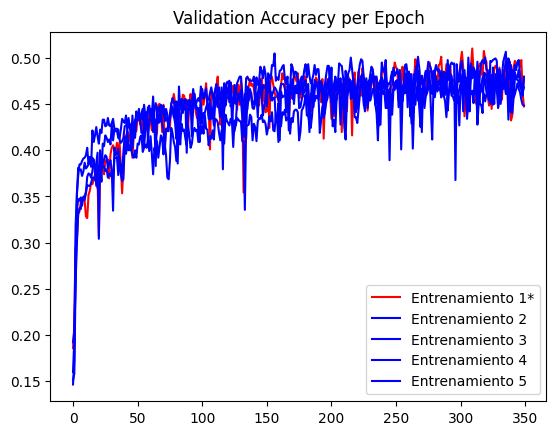

------------------------------------


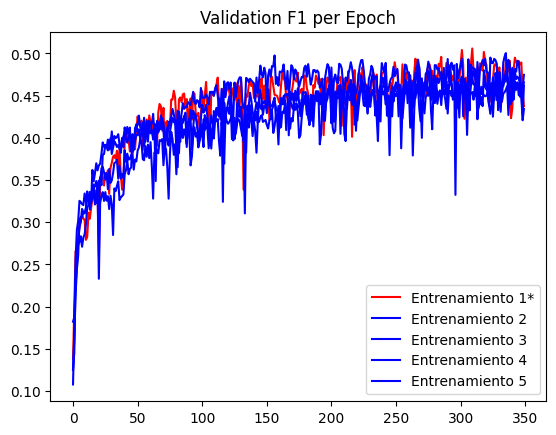

Best Validation accuracy: 0.51
Best Validation F1: 0.51


In [ ]:
F1Score = []
for i in range(5):
  F1Score.append(max(vanilla_rnn_training_curves_list[i][4]))
best_model = F1Score.index(max(F1Score))

for i in range(5):
  if i == best_model:
    plt.plot(range(len(vanilla_rnn_training_curves_list[i][0])), vanilla_rnn_training_curves_list[i][0], color='red', label=f'Entrenamiento {i+1}*')
  else:
    plt.plot(range(len(vanilla_rnn_training_curves_list[i][0])), vanilla_rnn_training_curves_list[i][0], color='blue', label=f'Entrenamiento {i+1}')
plt.legend()
plt.title('Training Loss per Epoch')
plt.show()
print('------------------------------------')
for i in range(5):
  if i == best_model:
    plt.plot(range(len(vanilla_rnn_training_curves_list[i][1])), vanilla_rnn_training_curves_list[i][1], color='red', label=f'Entrenamiento {i+1}*')
  else:
    plt.plot(range(len(vanilla_rnn_training_curves_list[i][1])), vanilla_rnn_training_curves_list[i][1], color='blue', label=f'Entrenamiento {i+1}')
plt.legend()
plt.title('Validation Loss per Epoch')
plt.show()
print('------------------------------------')
for i in range(5):
  if i == best_model:
    plt.plot(range(len(vanilla_rnn_training_curves_list[i][2])), vanilla_rnn_training_curves_list[i][2], color='red', label=f'Entrenamiento {i+1}*')
  else:
    plt.plot(range(len(vanilla_rnn_training_curves_list[i][2])), vanilla_rnn_training_curves_list[i][2], color='blue', label=f'Entrenamiento {i+1}')
plt.legend()
plt.title('Train Accuracy per Epoch')
plt.show()
print('------------------------------------')
for i in range(5):
  if i == best_model:
    plt.plot(range(len(vanilla_rnn_training_curves_list[i][3])), vanilla_rnn_training_curves_list[i][3], color='red', label=f'Entrenamiento {i+1}*')
  else:
    plt.plot(range(len(vanilla_rnn_training_curves_list[i][3])), vanilla_rnn_training_curves_list[i][3], color='blue', label=f'Entrenamiento {i+1}')
plt.legend()
plt.title('Validation Accuracy per Epoch')
plt.show()
print('------------------------------------')
for i in range(5):
  if i == best_model:
    plt.plot(range(len(vanilla_rnn_training_curves_list[i][4])), vanilla_rnn_training_curves_list[i][4], color='red', label=f'Entrenamiento {i+1}*')
  else:
    plt.plot(range(len(vanilla_rnn_training_curves_list[i][4])), vanilla_rnn_training_curves_list[i][4], color='blue', label=f'Entrenamiento {i+1}')
plt.legend()
plt.title('Validation F1 per Epoch')
plt.show()

print(f"Best Validation accuracy: {np.round(max(vanilla_rnn_training_curves_list[best_model][3]),2)}")
print(f"Best Validation F1: {np.round(max(vanilla_rnn_training_curves_list[best_model][4]),2)}")


Luego, analizando la matriz de confusión utilizando el conjunto de prueba, se puede observar que el modelo (en las 5 iteraciones de entrenamiento) logra clasificar de muy buena manera la emoción "Enojo", alcanzando un accuracy promedio de 74.5% con una desviación estándar de 11.2%. Mientras que las emociones "Miedo" y "Disgusto" fueron las peores clasificadas, alcanzando un accuracy promedio de 32.9% con desviación estándar de 3.5% y 34.5% con desviación estándar de 7.4% respectivamente. Luego, considerando el promedio de accuracy de todas las clases, con las 5 iteraciones de entrenamiento se alcanzó un accuracy promedio de 48% con desviación estándar de 1%.

Mientras que al analizar la matriz de confusión en el conjunto de prueba del modelo con mejor F1 Score alcanzado durante el entrenamiento, se puede ver que la emoción "Enojo" sigue siendo la mejor clasificada con un 74.8% de accuracy, mientras que la emoción "Disgusto" es la peor clasificada con un accuracy de 28.5%. En cuanto al accuracy promedio del mejor modelo, este alcanzó un valor de 50%.

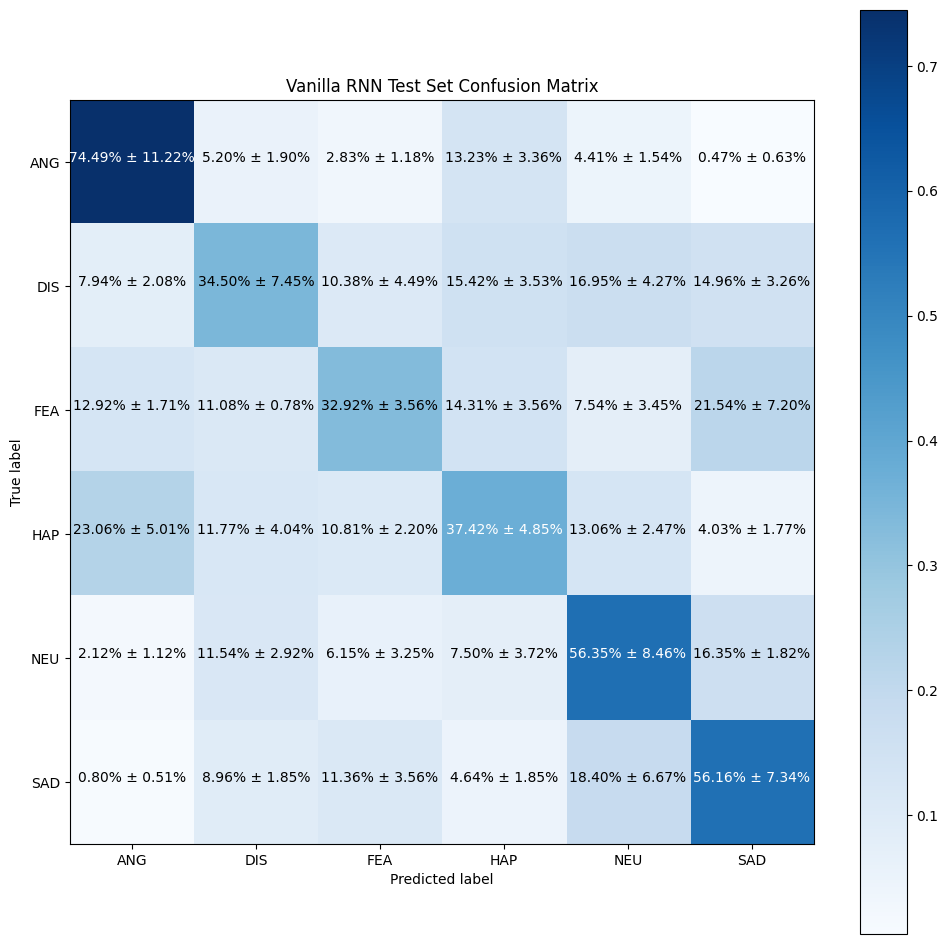

Accuracy for Test Set: 0.48 ± 0.01



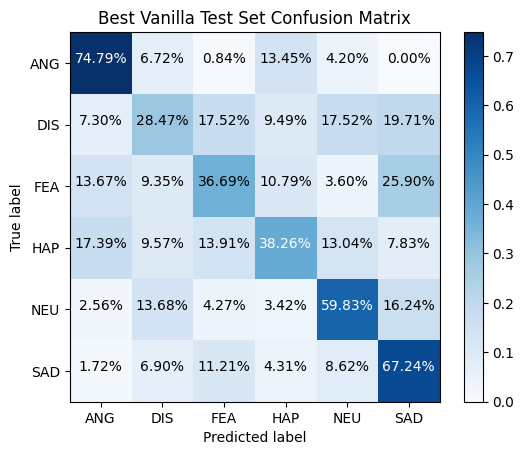

Best Accuracy for Test Set: 0.5


In [12]:
confusion = np.zeros((5,6,6))
for i in range(5):
  winner_model = ModelVanillaRNN(learning_rate=learning_rate).to(device)
  winner_model.load_state_dict(torch.load(f"/content/results/weights_vanilla_{i}.pt"))
  winner_model.eval()
  with torch.no_grad():
    confusion[i] = winner_model.get_confusion_matrix(torch.load(f"/content/test/input_vanilla_{i}.pt"),
                                                     torch.load(f"/content/test/target_vanilla_{i}.pt")).cpu().numpy().astype(np.int64)

show_statistics(confusion, network="Vanilla RNN Test Set")

accs = []
for i in range(5):
  accs.append(np.sum(np.diag(confusion[i])) / np.sum(confusion[i]))

print(f'Accuracy for Test Set: {np.round(np.mean(accs),2)} ± {np.round(np.std(accs),2)}\n')

show_confusion_matrix(confusion[np.argmax(accs)], network='Best Vanilla Test Set')
print(f'Best Accuracy for Test Set: {np.round(np.max(accs),2)}')

<h2>LSTM RNN: Implementación</h2>

Utilizando los mismos parámetros para la secuencia de entrada que se consideraron para el modelo Vanilla, es decir, $T=19$ pasos y $F=26$ características por paso y un valor de $C=6$ clases posibles.

$$ h_0 = \vec{0}$$
$$ c_0 = \vec{0}$$
$$ h_k, c_k = \mathrm{LSTM}(x_k, h_{k-1}, c_{k-1}),\ \ k\in\{1,2,\ldots, T\}$$
$$ z = W_zh_T+b_z$$
$$\hat{y} = \mathrm{argmax}(z)$$

Donde $h_k,\ c_k\in\mathbb{R}^H$ son respectivamente el estado oculto y la memoria, $H$ es la dimensionalidad de la capa recurrente, $h_0,\ c_0$ son estados iniciales nulos, $W_z$ y $b_z$ son los pesos y sesgos de la capa de salida, $z\in\mathbb{R}^C$ son los logits calculados a partir del último estado $h_T$, e $\hat{y}\in\{0,1,\ldots,C-1\}$ es la clase predicha por la RNN.


In [ ]:
# Los metodos definidos para esta arquitectura son los mismos que para Vanilla,
# con diferencias unicamente en __init__() y forward(), asi como en los parámetros
# a optimizar en el optimizer del metodo fit(). Dado lo anterior, solo parte de dichas
# secciones será comentada, pues el detalle del funcionamiento del resto puede ser
# encontrado en los comentarios realizados en la clase ModelVanillaRNN.

class ModelLSTM(nn.Module):
    def __init__(
        self,
        learning_rate,
        n_input_features=26,
        n_input_steps=19,
        n_hidden_dimension=16,
        n_classes=6,
        batch_size=32,
        n_epochs=150
    ):
        super(ModelLSTM, self).__init__()
        self.learning_rate = learning_rate
        self.n_input_features = n_input_features
        self.n_input_steps = n_input_steps
        self.n_hidden_dimension = n_hidden_dimension
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.n_epochs = n_epochs

        self.CE = FocalLossSoftMax(gamma=3.0)
        # Se definen las funciones de activacion que seran usadas.
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()

        # Se definen las capas de la celda, donde el nombre de cada una es representativo de su funcion.
        # Ademas se comenta al lado de cada una la funcion de activacion que sera aplicada sobre dicha capa
        # durante el uso de la red.
        self.forget = torch.nn.Linear(self.n_input_features + self.n_hidden_dimension, self.n_hidden_dimension) #sigmoide
        nn.init.kaiming_uniform_(self.forget.weight.data)
        nn.init.ones_(self.forget.bias.data)
        self.in_gate = torch.nn.Linear(self.n_input_features + self.n_hidden_dimension, self.n_hidden_dimension) #sigmoide
        nn.init.kaiming_uniform_(self.in_gate.weight.data)
        self.candidates = torch.nn.Linear(self.n_input_features + self.n_hidden_dimension, self.n_hidden_dimension) #tanh
        nn.init.kaiming_uniform_(self.candidates.weight.data)
        self.o = torch.nn.Linear(self.n_input_features + self.n_hidden_dimension, self.n_hidden_dimension) #sigmoide
        nn.init.kaiming_uniform_(self.o.weight.data)

        # Se define la capa de salida, que actua de clasificador.

        self.fc1 = torch.nn.Linear(self.n_hidden_dimension, self.n_input_steps)
        nn.init.kaiming_uniform_(self.fc1.weight.data)

        self.fc = torch.nn.Linear(self.n_input_steps, self.n_classes)
        nn.init.kaiming_uniform_(self.fc.weight.data)

        self.ReLU = nn.ReLU()

        self.bn = nn.BatchNorm1d(self.n_input_steps).to(device)

        self.confusion_matrix = ConfusionMatrix(num_classes=self.n_classes, task='multiclass')

    def forward(self, batch):
        h_k = torch.zeros(len(batch), self.n_hidden_dimension).type(torch.FloatTensor).to(device)
        C_k = torch.zeros(len(batch), self.n_hidden_dimension).type(torch.FloatTensor).to(device)

        for step in range(self.n_input_steps):
          x_k = torch.cat((batch[:, step, :], h_k), 1)
          # Se calcula la salida de la compuerta forget.
          f = self.forget(x_k)
          f = self.sigmoid(f)

          # Se calculan las salidas de la compuerta input_gate, con información
          # de las componentes relevantes; y los candidatos a ser elegidos por
          # la input_gate como fuente de informacion relevante.
          i = self.in_gate(x_k)
          i = self.sigmoid(i)
          c = self.candidates(x_k)
          c = self.tanh(c)

          # Se actualiza el estado de memoria de la celda.
          C_k = f*C_k + i*c

          # Se obtienen las componentes relevantes del estado de memoria para
          # actualizar el estado de la celda.
          o = self.o(x_k)
          o = self.sigmoid(o)

          # Se actualiza el estado de la celda con las componentes elegidas.
          h_k = o*self.tanh(C_k)

        # h_T es entregado al clasificador y se retorna el resultado.

        z = self.fc(self.ReLU(self.bn(self.fc1(h_k))))
        return z

    def fit(self, x_train, y_train, x_val, y_val, it):
        # Se crea el optimizador con todas las variables a actualizar
        # de cada una de las capas de la LSTM.
        optimizer = torch.optim.AdamW([
            {'params': [self.fc.weight, self.fc.bias,
                        self.o.weight, self.o.bias,
                        self.candidates.weight, self.candidates.bias,
                        self.in_gate.weight, self.in_gate.bias,
                        self.forget.weight, self.forget.bias,
                        self.fc1.weight, self.fc1.bias,
                        self.bn.weight, self.bn.bias]}],
            lr=self.learning_rate,
            betas=(0.9, 0.999))


        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                                                      base_lr=self.learning_rate,
                                                      max_lr=10*self.learning_rate,
                                                      cycle_momentum=False,
                                                      step_size_up=750)


        xentropy = self.CE

        train_loss = np.zeros(self.n_epochs)
        val_loss = np.zeros(self.n_epochs)
        train_accuracy = np.zeros(self.n_epochs)
        val_accuracy = np.zeros(self.n_epochs)
        val_F1 = np.zeros(self.n_epochs)

        len_y_train = len(y_train)
        len_y_val = len(y_val)

        progress = tqdm(range(self.n_epochs))

        best = 0

        early = 0

        for epoch in progress:
          self.train()
          indices = torch.randperm(x_train.shape[0])
          x_train = x_train[indices]
          y_train = y_train[indices]

          for run in range(len_y_train//self.batch_size):

            x_batch = x_train[run*self.batch_size : (run+1)*self.batch_size].to(device)
            y_target = y_train[run*self.batch_size : (run+1)*self.batch_size].to(device)
            z_pred = self.forward(x_batch)

            optimizer.zero_grad()
            loss = xentropy(z_pred, y_target)
            loss.backward()
            optimizer.step()
            scheduler.step()

          self.eval()
          train_loss[epoch] = self.eval_loss(x_train, y_train)
          val_loss_epoch = self.eval_loss(x_val, y_val)
          val_loss[epoch] = val_loss_epoch
          train_accuracy[epoch], F1_train = self.evaluate(x_train, y_train)
          val_accuracy[epoch], F1_val = self.evaluate(x_val, y_val)
          val_F1[epoch] = np.mean(F1_val)

          if np.mean(val_F1[epoch]) > best:
            best = np.mean(val_F1[epoch])
            torch.save(self.state_dict(), f"/content/results/weights_lstm_{it}.pt")

          progress.set_postfix({'loss validation': val_loss_epoch})

        try:
          training_curves = (train_loss[:np.min(np.where(train_loss==0)[0])],
                             val_loss[:np.min(np.where(val_loss==0)[0])],
                             train_accuracy[:np.min(np.where(train_accuracy==0)[0])],
                             val_accuracy[:np.min(np.where(val_accuracy==0)[0])],
                             val_F1[:np.min(np.where(val_F1==0)[0])])
        except:
          training_curves = (train_loss,
                             val_loss,
                             train_accuracy,
                             val_accuracy,
                             val_F1)

        return training_curves

    def evaluate(self, x, y):
        batch_size = len(y)

        # Mediante la matriz de confusion, se obtiene el accuracy sumando los elementos
        # de la diagonal y dividiendo dicha suma por el total de elementos ingresados,
        # y luego se retorna dicho valor.
        confusion = self.get_confusion_matrix(x, y)

        F1 = self.F1(confusion.cpu().numpy())

        accuracy = (torch.sum(torch.Tensor([confusion[n,n] for n in range(self.n_classes)])) / batch_size)

        return accuracy, F1


    def get_confusion_matrix(self, x, y):

      z = self.forward(x.to(device))
      pred = torch.argmax(z, dim=1)

      return self.confusion_matrix(pred, y.to(device))

    def F1(self, cm):
      FP = cm.sum(axis=0) - np.diag(cm)
      FN = cm.sum(axis=1) - np.diag(cm)
      TP = np.diag(cm)

      # F1 Score
      F1 = TP/(TP+ 0.5*(FP+FN))
      return F1


    def eval_loss(self, x, z):
      with torch.no_grad():
        z_pred = self.forward(x.to(device))
        loss = self.CE(z_pred, z.to(device))
      return loss.cpu().item()

<h2>LSTM RNN: Entrenamiento</h2>

Entrenamiento del modelo LSTM con las mismas instrucciones entregadas para Vanilla RNN.

In [ ]:
learning_rate = 0.0001

lstm_rnn_training_curves_list = []
lstm_rnn_val_accuracy_list = []
for i in range(5):
    x_train, x_val, x_test, y_train, y_val, y_test = split_data(x_set, x_set_mfcc, y_set, network='lstm', it=i)
    my_rnn = ModelLSTM(learning_rate=learning_rate, n_epochs=350).to(device)
    # Train model
    training_curves = my_rnn.fit(x_train, y_train, x_val, y_val, it = i)
    # Evaluate model
    val_accuracy = my_rnn.evaluate(x_val, y_val)
    # Save reports for later
    lstm_rnn_training_curves_list.append(training_curves)
    lstm_rnn_val_accuracy_list.append(val_accuracy)

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

<h2>LSTM RNN: Análisis</h2>

A continuación se observan las curvas de entrenamiento y validación de cada una de las 5 iteraciones que se realizaron para entrenar. Destacar que, al igual que como se hizo con los gráficos del modelo Vanilla RNN, en cada uno de estos, se identifica el modelo con mejores resultados como una curva de color rojo, mientras que el resto de curvas son de color azul.

Al analizar las curvas de pérdidas se puede observar que tanto para los casos de entrenamiento y validación los valores presentan una tendencia a la baja, alcanzando valores bajo 0.4 hacia el final de la curva de entrenamiento, y ligeramente mayor a 0.5 hacia el final de la curva de validación. Lo cual es bueno pues significa que el modelo está aprendiendo, así como también no se observa un aumento significativo en las curvas de pérdidas, lo que significa que el modelo no se está sobreajustando y aún es capaz de generalizar ante datos que desconoce.

Luego, al analizar las curvas de accuracy de entrenamiento y validación, se puede ver que en ambos casos los modelos presentan un aprendizaje rápido durante las primera épocas, para luego alcanzar un plateau sobre 0.6 para el conjunto de entrenamiento y sobre 0.55 para el conjunto de validación, por lo que se puede considerar que los modelos lograron aprender en base a los features entregados y a la arquitectura diseñada.

Finalmente, analizando el gráfico de F1 Score para el conjunto de validación, se puede ver que las curvas convergen y se estabilizan a medida que pasan las épocas. Lo que se mantiene acorde con los comportamientos de las curvas presentadas en los gráficos anteriores. Por otra parte, el entrenamiento que presentó mejor F1 Score correspondió a la iteración 4, teniendo un F1 Score de 0.58 y un accuracy de 0.58 igualmente.

Al igual a como se observó en los gráficos obtenidos con el modelo Vanilla RNN, los gráficos del modelo LSTM RNN también presenta peaks constantes en los comportamientos de sus curvas, las cuales también se deben al cycling learning rate.

Al igual a como se dió con el modelo Vanilla RNN, un F1 Score de ligeramente superior a 0.5 muestra que aún hay posible márgen de mejora.

best f1: 0.5797091282264811


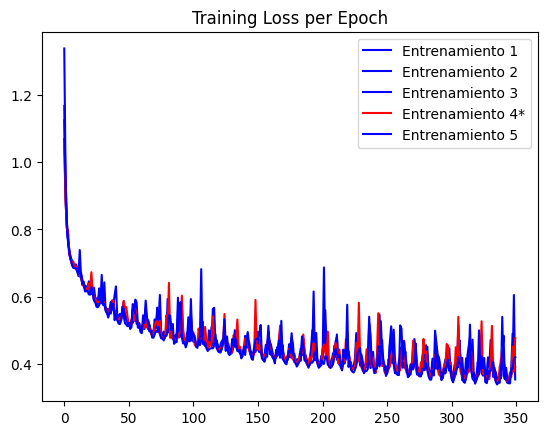

------------------------------------


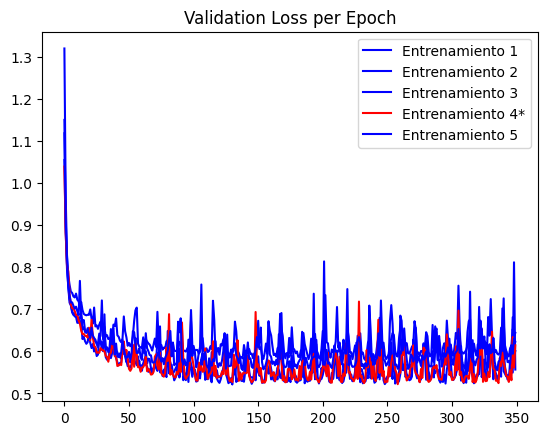

------------------------------------


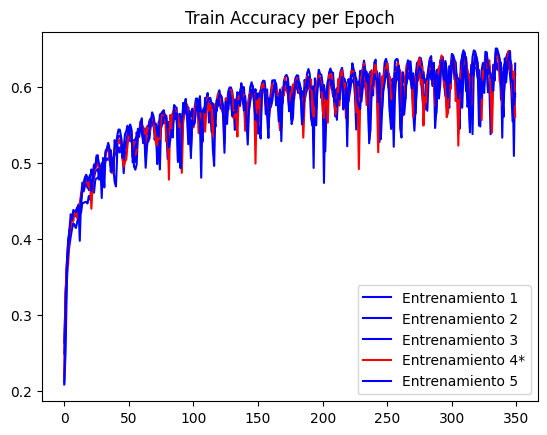

------------------------------------


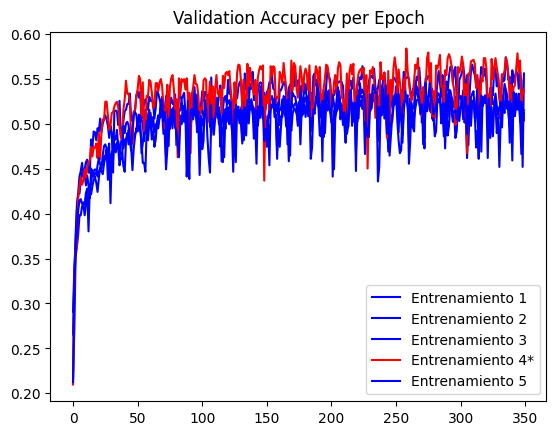

------------------------------------


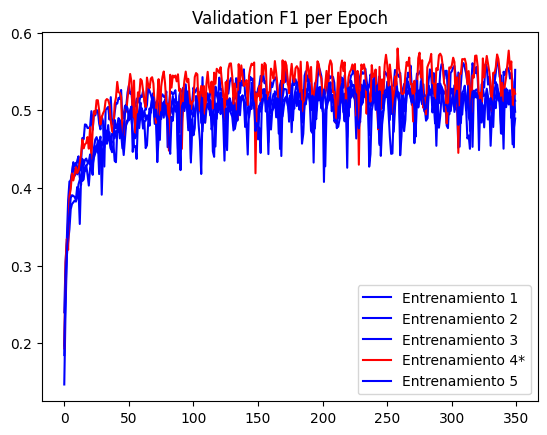

Best Validation accuracy: 0.58
Best Validation F1: 0.58


In [ ]:
f1 = []
for i in range(5):
  f1.append(max(lstm_rnn_training_curves_list[i][4]))
best_model = f1.index(max(f1))
print('best f1:', max(f1))

for i in range(5):
  if i == best_model:
    plt.plot(np.arange(len(lstm_rnn_training_curves_list[i][0])), lstm_rnn_training_curves_list[i][0], color='red', label=f'Entrenamiento {i+1}*')
  else:
    plt.plot(np.arange(len(lstm_rnn_training_curves_list[i][0])), lstm_rnn_training_curves_list[i][0], color='blue', label=f'Entrenamiento {i+1}')
plt.legend()
plt.title('Training Loss per Epoch')
plt.show()
print('------------------------------------')
for i in range(5):
  if i == best_model:
    plt.plot(np.arange(len(lstm_rnn_training_curves_list[i][1])), lstm_rnn_training_curves_list[i][1], color='red', label=f'Entrenamiento {i+1}*')
  else:
    plt.plot(np.arange(len(lstm_rnn_training_curves_list[i][1])), lstm_rnn_training_curves_list[i][1], color='blue', label=f'Entrenamiento {i+1}')
plt.legend()
plt.title('Validation Loss per Epoch')
plt.show()
print('------------------------------------')
for i in range(5):
  if i == best_model:
    plt.plot(np.arange(len(lstm_rnn_training_curves_list[i][2])), lstm_rnn_training_curves_list[i][2], color='red', label=f'Entrenamiento {i+1}*')
  else:
    plt.plot(np.arange(len(lstm_rnn_training_curves_list[i][2])), lstm_rnn_training_curves_list[i][2], color='blue', label=f'Entrenamiento {i+1}')
plt.legend()
plt.title('Train Accuracy per Epoch')
plt.show()
print('------------------------------------')
for i in range(5):
  if i == best_model:
    plt.plot(np.arange(len(lstm_rnn_training_curves_list[i][3])), lstm_rnn_training_curves_list[i][3], color='red', label=f'Entrenamiento {i+1}*')
  else:
    plt.plot(np.arange(len(lstm_rnn_training_curves_list[i][3])), lstm_rnn_training_curves_list[i][3], color='blue', label=f'Entrenamiento {i+1}')
plt.legend()
plt.title('Validation Accuracy per Epoch')
plt.show()
print('------------------------------------')
for i in range(5):
  if i == best_model:
    plt.plot(np.arange(len(lstm_rnn_training_curves_list[i][4])), lstm_rnn_training_curves_list[i][4], color='red', label=f'Entrenamiento {i+1}*')
  else:
    plt.plot(np.arange(len(lstm_rnn_training_curves_list[i][4])), lstm_rnn_training_curves_list[i][4], color='blue', label=f'Entrenamiento {i+1}')
plt.legend()
plt.title('Validation F1 per Epoch')
plt.show()

print(f"Best Validation accuracy: {np.round(max(lstm_rnn_training_curves_list[best_model][3]),2)}")
print(f"Best Validation F1: {np.round(max(lstm_rnn_training_curves_list[best_model][4]),2)}")


Luego, analizando la matriz de confusión utilizando el conjunto de prueba, se puede observar que el modelo (en las 5 iteraciones de entrenamiento) logra clasificar de muy buena manera las emociones "Enojo" y "Neutral", alcanzando un accuracy promedio de 70.8% con desviación estándar de 7.7% y un accuracy promedio de 65% con desviación estándar de 10% respectivamente. Mientras que la emoción "Disgusto" fue la peor clasificada, alcanzando un accuracy promedio de 40.3% con desviación estándar de 5.5%. Luego, considerando el promedio de accuracy de todas las clases, con las 5 iteraciones de entrenamiento se alcanzó un accuracy promedio de 55% con desviación estándar de 3%.

Mientras que al analizar la matriz de confusión en el conjunto de prueba del modelo con mejor F1 Score alcanzado durante el entrenamiento, se puede ver que la emoción "Neutral" es la mejor clasificada con un 76.3% de accuracy seguido por la emoción "Enojo" con un accuracy de 72.1%, mientras que la emoción "Disgusto" es la peor clasificada con un accuracy de 46.5% siendo ligeramente superada por la emoción "Felicidad" con un accuracy de 48%. En cuanto al accuracy promedio del mejor modelo, este alcanzó un valor de 59%. Siendo un muy buen resultado.

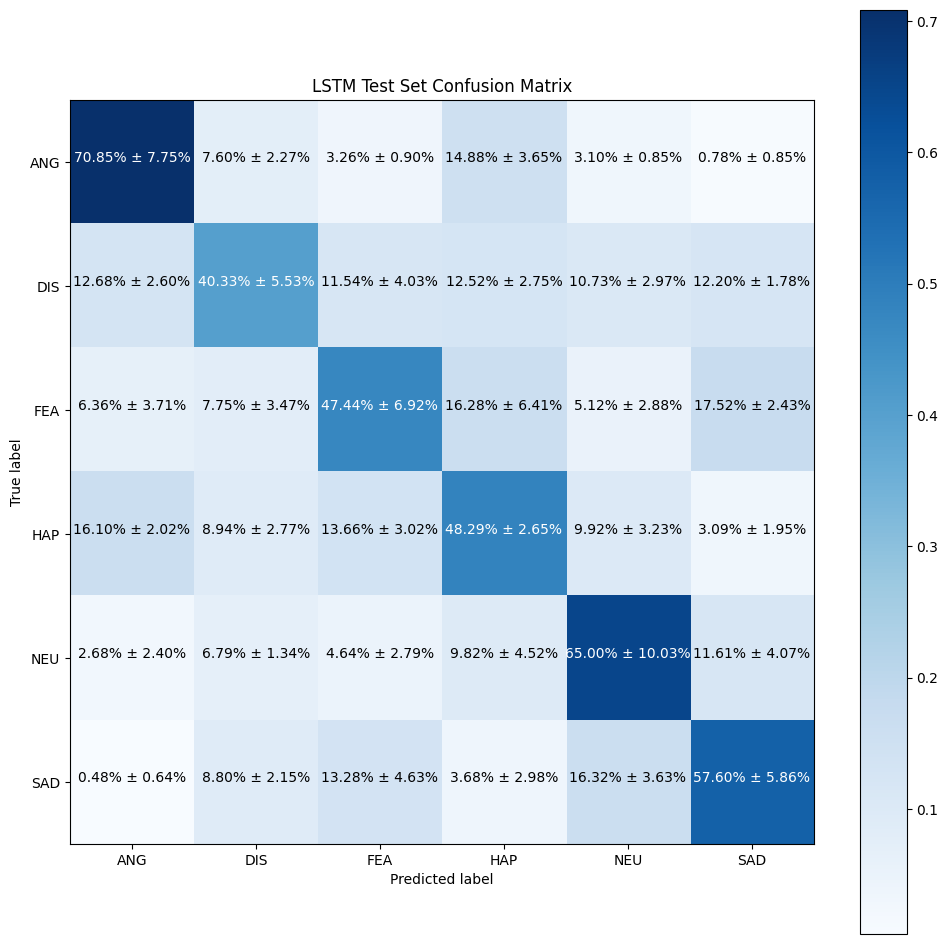

Accuracy for Test Set: 0.55 ± 0.03



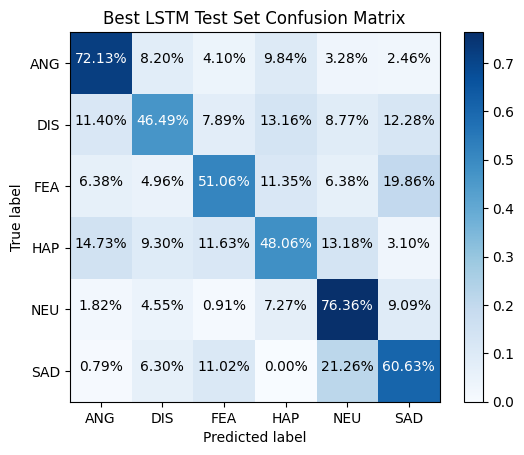

Best Accuracy for Test Set: 0.59


In [ ]:
confusion = np.zeros((5,6,6))
for i in range(5):
  winner_model = ModelLSTM(learning_rate=0.001).to(device)
  winner_model.load_state_dict(torch.load(f"/content/results/weights_lstm_{i}.pt"))
  winner_model.eval()
  with torch.no_grad():
    confusion[i] = winner_model.get_confusion_matrix(torch.load(f"/content/test/input_lstm_{i}.pt"),
                                                     torch.load(f"/content/test/target_lstm_{i}.pt")).cpu().numpy().astype(np.int64)

show_statistics(confusion, network="LSTM Test Set")

accs = []
for i in range(5):
  accs.append(np.sum(np.diag(confusion[i])) / np.sum(confusion[i]))

print(f'Accuracy for Test Set: {np.round(np.mean(accs),2)} ± {np.round(np.std(accs),2)}\n')

show_confusion_matrix(confusion[np.argmax(accs)], network='Best LSTM Test Set')
print(f'Best Accuracy for Test Set: {np.round(np.max(accs),2)}')

In [ ]:
from google.colab import files

for i in os.listdir('/content/results'):
 files.download('/content/results/'+i)
for i in os.listdir('/content/test'):
 files.download('/content/test/'+i)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusión

Comparando los rendimientos y resultados de las arquitecturas Vanilla RNN y LSTM RNN, se puede notar que LSTM logra una mejor identificación de las distintas emociones al analizar los coeficientes LPC y MFCC de los audios, lo cual se ve reflejado en las curvas de accuracy y F1 Score en los conjuntos de entrenamiento y validación, en donde los valores de los modelos LSTM fueron, en general, mejores que los obtenidos para los modelos Vanilla. Destacar que las curvas de pérdidas no se pueden comparar directamente dado que se utilizaron gammas distintos para el cycling learning rate scheduler.

Esto es confirmado luego al analizar las matrices de confusión utilizando el conjunto de prueba, en donde ambas arquitecturas logran identificar de buena manera la emoción "Enojo", alcanzando accuracys promedio mayor a 70% en ambos casos. Sin embargo, la segunda emoción mejor clasificada correspondiente a "Neutral" alcanzó un accuracy promedio de 65% para los modelos LSTM, mientras que para los modelos Vanilla alcanzó un accuracy promedio de 56%. Por otra parte, las emociones peor clasificadas por ambas arquitecturas alcanzaron un accuracy promedio de 40% para los modelos LSTM (correspondiente a la emoción "Disgusto") y un accuracy promedio de 32% para los modelos Vanilla (correspondiente a la emoción "Miedo").

Comparando los resultados obtenidos por el modelo LSTM RNN con el estado del arte del año 2020 (primer link en referencias), época en que aún no se utilizaban modelos Transformers, se tiene que para el estado del arte, utilizando los audios en compañía de las grabaciones visuales de estos, el mejor resultado logró obtener un accuracy de 55%. Con los modelos LSTM, en este proyecto se logró igualar este valor de forma estadística, alcanzando un accuracy promedio de 55% y un error de 3%, pero el mejor modelo LSTM alcanzó un accuracy de 59% (aproximadamente un 10% mejor que el resultado obtenido en el estado del arte), por lo que se puede considerar que el trabajo con los coeficientes LPC y MFCC es más efectivo que utilizar las grabaciones audiovisuales.

Es importante destacar que se decidió entrenar todos los modelos durante 350 épocas ya que se notó que en este punto ya se alcanza un plateau estable por lo que seguir entrenando por más épocas no generaría un mayor impacto. No obstante, es importante señalar que es posible que si se siguen entrenando los modelos durante más épocas, los resultados pueden mejorar ligeramente.

## Links

## Referencias

https://arxiv.org/pdf/2001.04316v2.pdf [estado del arte 2020 con Redes Recurrentes]

https://ieeexplore.ieee.org/document/10049941 [estado del arte actual con Transformers]

https://ieeexplore.ieee.org/document/9621964

https://ieeexplore.ieee.org/document/8300161

https://www.mdpi.com/1424-8220/23/3/1743

## Link a GitHub

https://github.com/GioCastiglioni/Proyecto_Voz